<a href="https://colab.research.google.com/github/gaby-baratela/ifsp_s1_bitcoin/blob/main/MODEL_yahoo_bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ambiente

In [1]:
%%capture
!pip install --upgrade pip
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install cmasher
!pip install pytrends

## Bibliotecas

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import swifter
# import warnings
# import cmasher as cmr

import pandas_datareader.data as web
from pytrends.request import TrendReq

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.figure_factory as ff
from dash import Dash, dcc, html, Input, Output

from sklearn.preprocessing import MinMaxScaler

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 500)
pd.set_option('display.expand_frame_repr', True)
# warnings.simplefilter(action='ignore', category=FutureWarning)

## Variáveis globais

In [3]:
#@title parâmetros de formatação dos gráficos {display-mode: "form"}
plotly_kwargs = dict(
    title_x=0.5,
    autosize=False,
    plot_bgcolor='white',
    margin=dict(l=2, r=10, t=30, b=2),
    width=1000,
    height=500,
    hovermode='x unified',
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    )
)

In [4]:
cores_tema = {
   'verde_claro': '#8DD8D3',
   'verde_escuro': '#599191', 
   'azul_petroleo': '#0B6374',
   'cinza_escuro': '#424242',
   'azul_bic': '#27278B', 
    'azul':'#1b86b9',
   'laranja': '#C0791B',  
   'vermelho': '#FD5B58', 
   'rosa': '#D558AB',
   'amarelado': '#D7E6A3'
}

In [5]:
periodo = pd.to_datetime(['2017-06-01', '2022-05-31'])

### Funções úteis

In [6]:
def create_corr_plot(series, nlags=None, plot_pacf=False):
    corr_array = pacf(series.dropna(), nlags=nlags, alpha=0.05) if plot_pacf else acf(series.dropna(), nlags=nlags, alpha=0.05)
    lower_y = corr_array[1][:,0] - corr_array[0]
    upper_y = corr_array[1][:,1] - corr_array[0]

    fig = go.Figure()
    [fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='#3f3f3f') 
     for x in range(len(corr_array[0]))]
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                   marker_size=12)
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=upper_y, mode='lines', line_color='rgba(255,255,255,0)')
    fig.add_scatter(x=np.arange(len(corr_array[0])), y=lower_y, mode='lines',fillcolor='rgba(32, 146, 230,0.3)',
            fill='tonexty', line_color='rgba(255,255,255,0)')
    fig.update_traces(showlegend=False)
    fig.update_xaxes(range=[-1,42])
    fig.update_yaxes(zerolinecolor='#000000')
    
    title='Partial Autocorrelation (PACF)' if plot_pacf else 'Autocorrelation (ACF)'
    fig.update_layout(title=title, **plotly_kwargs)
    
    return fig

# Coleta dos dados

## Bitcoin - Yahoo

In [7]:
btc = web.DataReader('BTC-USD', data_source='yahoo', start=periodo[0], end=periodo[1])

# Ajustando nomes das colunas
btc.columns = ['btc_' + c.lower() for c in btc.columns]
btc = btc.rename(columns={'btc_adj close':'btc'})

In [8]:
btc.tail()

,btc_high,btc_low,btc_open,btc_close,btc_volume,btc
Date,,,,,,
2022-05-28,28814.900391,28554.566406,28622.625000,28814.900391,35519577634,28814.900391
2022-05-29,29498.009766,28841.107422,29019.867188,29445.957031,18093886409,29445.957031
2022-05-30,31949.630859,29303.572266,29443.365234,31726.390625,39277993274,31726.390625
2022-05-31,32249.863281,31286.154297,31723.865234,31792.310547,33538210634,31792.310547
2022-06-01,31957.285156,29501.587891,31792.554688,29799.080078,41135817341,29799.080078


*Sobre os dados*:

1. Date: This is the index in our time series that specifies the date associated with the price.

2. Close: The last price at which BTC was purchased on that day.

3. Open: The first price at which BTC was purchased on that day.

4. High: The highest price at which BTC was purchased that day.

5. Low:  The lowest price at which BTC was purchased that day.

6. Volume: The number of total trades that day.

7. Adj Close: The closing price adjusted for dividends and stock splits.

## Pytrends - interesse ao longo do tempo

In [9]:
# Conexão com google
bittrends = TrendReq(hl='en-US', tz=360) 

# Puxando dados
bittrends.build_payload(['bitcoin'], cat=0, timeframe=" ".join(periodo.astype(str)), geo='') 
btc_iot = bittrends.interest_over_time() 

# Filtro 
btc_iot = btc_iot[~btc_iot['isPartial']]

# Ajustando colunas
btc_iot.index.names=['Date']
btc_iot = btc_iot.rename(columns={'bitcoin':'iot'}).drop(columns=['isPartial'])

## Yahoo - Outras criptomoedas + Indices Americanos

In [10]:
tickers = ['USDT-USD', 'ETH-USD'] + ["^NDXT", '^GSPC', "USDBRL=x"] # criptos + indices
ticker_names = ['usdt','eth', 'ndxt', 'sp500', 'usd']

In [11]:
df_yahoo = web.get_data_yahoo(tickers, start=periodo[0], end=periodo[1])["Adj Close"]
df_yahoo.columns=ticker_names

In [12]:
df_yahoo.head()

,usdt,eth,ndxt,sp500,usd
Date,,,,,
2017-05-31,NaN,NaN,NaN,NaN,3.2251
2017-06-01,NaN,NaN,3543.659912,2430.060059,3.2490
2017-06-02,NaN,NaN,3575.120117,2439.070068,NaN
2017-06-04,NaN,NaN,NaN,NaN,3.2492
2017-06-05,NaN,NaN,3572.870117,2436.100098,3.2961


In [13]:
df_yahoo.describe()

,usdt,eth,ndxt,sp500,usd
count,1666.000000,1666.000000,1259.000000,1259.000000,1302.000000
mean,1.001803,1095.076221,5761.728359,3285.857784,4.427419
std,0.006023,1254.715461,1867.700821,703.050502,0.865572
min,0.966644,84.308296,3360.489990,2237.399902,3.097600
25%,1.000033,199.851654,4244.975098,2737.155029,3.746225
50%,1.000660,407.698105,4952.959961,2984.870117,4.158950
75%,1.002970,1917.935577,7543.064941,3908.114990,5.290425
max,1.077880,4812.087402,9855.419922,4796.560059,5.886400


## Hash rate

Fonte: https://www.blockchain.com/pt/charts/hash-rate

In [14]:
hash_rate = pd.read_csv('data/hash-rate.csv')

# Ajustando data no index
hash_rate.index = pd.to_datetime(hash_rate['Timestamp']).dt.date
hash_rate.index.names = ['Date']

# Gerando df final
hash_rate = hash_rate.drop(columns='Timestamp').rename(columns={'hash-rate':'hash_rate'})

In [15]:
hash_rate.head()

,hash_rate
Date,
2009-01-03,4.971027e-08
2009-01-06,0.000000e+00
2009-01-09,6.959438e-07
2009-01-12,4.424214e-06
2009-01-15,6.313204e-06


## Funding rate

Fonte: https://www.binance.com/en/futures/funding-history/1

In [16]:
funding_rate = pd.read_csv('data/Funding Rate History.csv')

funding_rate['Date'] = pd.to_datetime(funding_rate['Time']).dt.date
funding_rate['funding_rate'] = pd.to_numeric(funding_rate['Funding Rate'].str.replace('%', ''))

funding_rate = funding_rate.groupby('Date').agg({'funding_rate':'mean'})

In [17]:
funding_rate.head()

,funding_rate
Date,
2019-09-10,0.01
2019-09-11,0.01
2019-09-12,0.01
2019-09-13,0.01
2019-09-14,0.01


## Unificação das bases

In [18]:
df_list = [btc, btc_iot, df_yahoo, hash_rate, funding_rate]

Ajuste de index para o join

In [19]:
df_concat = []
for df in df_list:
    # Ajuste de index para o join
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
    
    # Filtro de datas
    df = df.loc[(df.index>=periodo[0]) & (df.index<=periodo[1])]
    
    df_concat.append(df)

In [20]:
df_all = pd.concat(df_concat, axis=1)

In [21]:
df_all.head()

,btc_high,btc_low,btc_open,btc_close,btc_volume,btc,iot,usdt,eth,ndxt,sp500,usd,hash_rate,funding_rate
Date,,,,,,,,,,,,,,
2017-06-01,2448.389893,2288.330078,2288.330078,2407.879883,1653180032,2407.879883,NaN,NaN,NaN,3543.659912,2430.060059,3.2490,NaN,NaN
2017-06-02,2488.550049,2373.320068,2404.030029,2488.550049,1317030016,2488.550049,NaN,NaN,NaN,3575.120117,2439.070068,NaN,4.325022e+06,NaN
2017-06-03,2581.909912,2423.570068,2493.719971,2515.350098,1514950016,2515.350098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-04,2585.889893,2452.540039,2547.790039,2511.810059,1355120000,2511.810059,12.0,NaN,NaN,NaN,NaN,3.2492,NaN,NaN
2017-06-05,2686.810059,2510.219971,2512.399902,2686.810059,1369309952,2686.810059,NaN,NaN,NaN,3572.870117,2436.100098,3.2961,5.533581e+06,NaN


In [22]:
df_all.tail()

,btc_high,btc_low,btc_open,btc_close,btc_volume,btc,iot,usdt,eth,ndxt,sp500,usd,hash_rate,funding_rate
Date,,,,,,,,,,,,,,
2022-05-27,29346.943359,28326.613281,29251.140625,28627.574219,36582005748,28627.574219,NaN,0.998863,1724.922852,7137.759766,4158.240234,NaN,NaN,0.010000
2022-05-28,28814.900391,28554.566406,28622.625000,28814.900391,35519577634,28814.900391,NaN,0.999002,1757.941772,NaN,NaN,NaN,2.199588e+08,0.009567
2022-05-29,29498.009766,28841.107422,29019.867188,29445.957031,18093886409,29445.957031,NaN,0.999178,1812.031006,NaN,NaN,4.7296,NaN,0.010000
2022-05-30,31949.630859,29303.572266,29443.365234,31726.390625,39277993274,31726.390625,NaN,0.999376,1996.441284,NaN,NaN,4.7524,NaN,0.010000
2022-05-31,32249.863281,31286.154297,31723.865234,31792.310547,33538210634,31792.310547,NaN,0.999388,1942.328003,7042.379883,4132.149902,4.7304,2.169864e+08,0.010000


### Correção de valores ausentes

In [23]:
# Para ter certeza que não há buracos na série
df_all = df_all.apply(lambda group: group.reindex(pd.date_range(periodo[0], periodo[1], freq='D'), 
                                                  method='nearest')).sort_index()

### Interpolação de valores faltantes no meio da série

In [24]:
df_all = df_all.apply(lambda x: x.interpolate(method='time'))

In [25]:
df_all

,btc_high,btc_low,btc_open,btc_close,btc_volume,btc,iot,usdt,eth,ndxt,sp500,usd,hash_rate,funding_rate
2017-06-01,2448.389893,2288.330078,2288.330078,2407.879883,1653180032,2407.879883,NaN,NaN,NaN,3543.659912,2430.060059,3.249000,NaN,NaN
2017-06-02,2488.550049,2373.320068,2404.030029,2488.550049,1317030016,2488.550049,NaN,NaN,NaN,3575.120117,2439.070068,3.249067,4.325022e+06,NaN
2017-06-03,2581.909912,2423.570068,2493.719971,2515.350098,1514950016,2515.350098,NaN,NaN,NaN,3574.370117,2438.080078,3.249133,4.727875e+06,NaN
2017-06-04,2585.889893,2452.540039,2547.790039,2511.810059,1355120000,2511.810059,12.000000,NaN,NaN,3573.620117,2437.090088,3.249200,5.130728e+06,NaN
2017-06-05,2686.810059,2510.219971,2512.399902,2686.810059,1369309952,2686.810059,12.142857,NaN,NaN,3572.870117,2436.100098,3.296100,5.533581e+06,NaN
2017-06-06,2999.909912,2690.840088,2690.840088,2863.199951,2089609984,2863.199951,12.285714,NaN,NaN,3578.689941,2429.330078,3.276000,5.544828e+06,NaN
2017-06-07,2869.379883,2700.560059,2869.379883,2732.159912,1517709952,2732.159912,12.428571,NaN,NaN,3600.189941,2433.139893,3.267300,5.556075e+06,NaN
2017-06-08,2815.300049,2670.949951,2720.489990,2805.620117,1281170048,2805.620117,12.571429,NaN,NaN,3634.050049,2433.790039,3.259600,5.567322e+06,NaN
2017-06-09,2901.709961,2795.620117,2807.439941,2823.810059,1348950016,2823.810059,12.714286,NaN,NaN,3504.209961,2431.770020,3.232300,5.353627e+06,NaN
2017-06-10,2950.989990,2746.550049,2828.139893,2947.709961,2018889984,2947.709961,12.857143,NaN,NaN,3501.113281,2430.976644,3.205000,5.139932e+06,NaN


# Análises

## Gráficos das séries x BTC

In [26]:
variaveis = [x for x in df_all.columns if not 'btc' in x]

In [38]:
app = Dash('Correlações')

app.layout = html.Div([
    html.H4("Análise do histórico de variáveis x Bitcoin"),
    
    html.Div(className='row',children=[
        html.Label(['Variáveis:'], style={'font-weight': 'bold', "text-align": "center"}),
        html.Div(children= dcc.Dropdown(
            id='y-axis', 
            options=variaveis,
            value='usd', 
            searchable=False,
            clearable=True
        ), style=dict(width='15%'))], style=dict(display='flex')),
    dcc.Graph(id="graph"),
])

@app.callback(
    Output("graph", "figure"), 
    Input("y-axis", "value"))

def generate_chart(y):
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(go.Scatter(x=df_all.index, y=df_all['btc'], name='BTC', 
                             line=dict(color=cores_tema['verde_escuro'], width=1.2)))
    
    fig.add_trace(go.Scatter(x=df_all.index, y=df_all[y], name=y,
                             line=dict(color=cores_tema['amarelado'], width=1.2)),secondary_y=True)

    fig.update_traces(mode='lines')
    fig.update_layout(title='<b>Comparação BTC e covariáveis 2017-2022</b>', **plotly_kwargs)

    return fig

app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "Correlações" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


## Correlações

### Correlação com a resposta no tempo x

In [28]:
cols_cov = df_all.columns[~df_all.columns.str.contains('btc_')]
df_cov = df_all[cols_cov]

In [71]:
df_corr = df_cov.corr()

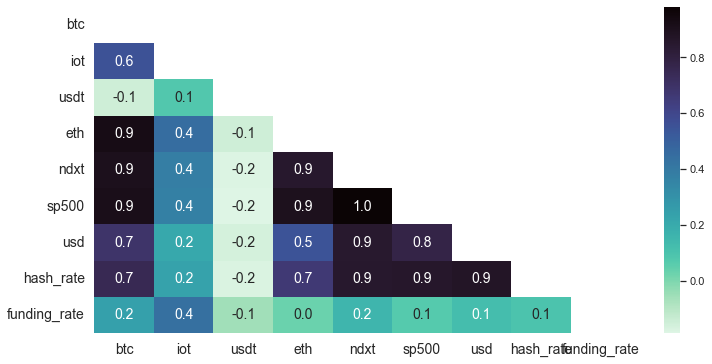

In [72]:
sns.set(rc={'figure.figsize':(12,6)})
sns.set_theme(style="whitegrid", rc={"axes.facecolor": (0, 0, 0, 0)})

mask = np.triu(np.ones_like(df_corr, dtype=bool))

fig = sns.heatmap(df_corr, annot=True, fmt='.1f', cmap='mako_r', mask=mask, annot_kws={'fontdict':{'fontsize':14}})
fig.set_ylabel("",fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=14)

plt.show(fig)

Aqui já percebemos que funding rate e usd theter não influenciam fortemente a BTC no mesmo período.

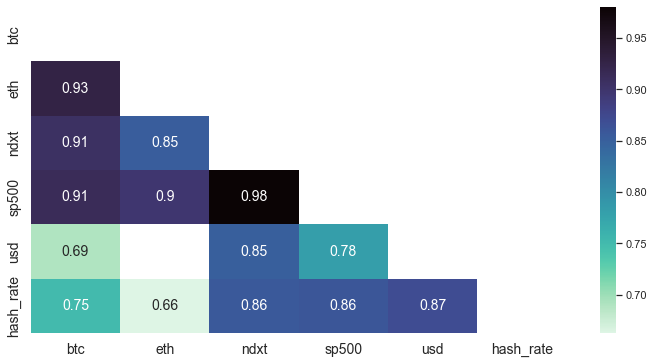

In [75]:
# filtrando as correlações maiores que +0.6 e menores que -0.6
corr_forte = df_corr[(df_corr > 0.65) | (df_corr < -0.65)]

# substituindo os valores das autocorrelações
corr_forte.replace(1,np.nan, inplace=True)

# retiando as linhas e colunas sem alta correlação
corr_forte.dropna(how='all', inplace=True, axis=1)
corr_forte.dropna(how='all', inplace=True)

plt.tick_params(axis='both', which='major', labelsize=14)

if len(corr_forte) :
  mask = np.triu(np.ones_like(corr_forte, dtype=bool))
  plt.show(sns.heatmap(corr_forte, annot=True, cmap='mako_r', mask=mask, annot_kws={'fontdict':{'fontsize':14}}));
else:
  print('Não há correlações significativas no conjunto de dados.')

Também devemos nos atentara ao uso da `eth` como covariável, por sua correlação com outras covariáveis e assim, podendo gerar multicolinearidade. Escolhemos `sp500` como covariável pois, além de ter alta correlação com `btc` também tem alta correlação com as demais.

### Correlação com a resposta em lag

In [32]:
lags = list(range(0,8))
mm = list(range(1,8))

In [33]:
df_lag_mm = df_cov
for l in lags:
    for m in mm:
        df_tmp = df_cov.drop(columns='btc').swifter.apply(lambda x: x.shift(l).rolling(m).mean())
        df_tmp.columns = [c + '-lag' + str(l) + '_mm' + str(m) for c in df_tmp.columns]
        
        df_lag_mm = pd.concat([df_lag_mm, df_tmp], axis=1)

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/8 [00:00<?, ?it/s]

In [34]:
df_lag_mm2 = df_lag_mm.melt(id_vars = 'btc', ignore_index=False, var_name='var', value_name='vlr')
df_lag_mm2[['var', 'lag_mm']] = df_lag_mm2['var'].str.split('-',expand=True)

In [35]:
df_corr_lag_mm = (
    df_lag_mm2
    .groupby(['var', 'lag_mm']).corr().reset_index()
    .query('level_2=="btc"').drop(columns=['btc', 'level_2'])
    .sort_values(['var', 'lag_mm', 'vlr'], ascending=False)
)

In [36]:
df_corr_lag_mm.groupby(['var'])['vlr'].max()

var
eth             0.927096
funding_rate    0.280134
hash_rate       0.750990
iot             0.555909
ndxt            0.907713
sp500           0.914567
usd             0.697530
usdt           -0.146586
Name: vlr, dtype: float64

Mesmo com todas as transformações, observamos que as duas variáveis citadas antes, `funding_rate` e `usdt` não possuem correlação com a variável resposta (`btc`), portanto serão descartadas do modelo. Além disso, a variável `iot` possui correlação baixa e será também desconsiderada.

In [37]:
df_corr_lag_mm[~df_corr_lag_mm['var'].isin(['iot', 'usdt', 'funding_rate'])].groupby('var').describe()

vlr                                                              \
          count      mean       std       min       25%       50%       75%   
var                                                                           
eth        56.0  0.911641  0.008002  0.896464  0.905236  0.911664  0.918076   
hash_rate  56.0  0.747654  0.002207  0.744040  0.745927  0.747804  0.749474   
ndxt       56.0  0.907234  0.000268  0.906689  0.907054  0.907235  0.907442   
sp500      56.0  0.911566  0.001815  0.907864  0.910173  0.911696  0.913067   
usd        56.0  0.694132  0.001817  0.690168  0.692789  0.694207  0.695564   

                     
                max  
var                  
eth        0.927096  
hash_rate  0.750990  
ndxt       0.907713  
sp500      0.914567  
usd        0.697530

Observamos também que, mesmo com as transformações de lag ou média móvel caso haja necessidade (se nossa previsão for realizada sem a projeção das covariáveis), ainda temos correlação significativa para o modelo. Isso pode se dar devido à interpolação feita para preenchimento dos dados.
Também observamos que a correlação não muda drasticamente entre as transformações, portanto podemos escolher qualquer uma delas para seguir com o modelo.

In [77]:
df_corr_lag_mm[df_corr_lag_mm['var']=='sp500']

,var,lag_mm,vlr
670,sp500,lag7_mm7,0.907864
668,sp500,lag7_mm6,0.908177
666,sp500,lag7_mm5,0.908502
664,sp500,lag7_mm4,0.908836
662,sp500,lag7_mm3,0.909163
660,sp500,lag7_mm2,0.909452
658,sp500,lag7_mm1,0.909687
656,sp500,lag6_mm7,0.908737
654,sp500,lag6_mm6,0.909059
652,sp500,lag6_mm5,0.909385
